In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630148 sha256=a5a97888a01892780249aa8b86a50b8b112709047490dddc61f2d8acc449cca0
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise import NormalPredictor
from surprise import KNNWithZScore
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import AlgoBase
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Read Data

In [ ]:
file = '/content/gdrive/MyDrive/dataset/Reviews.sqlite'

In [ ]:
con = sqlite3.connect(file)

In [ ]:
df = pd.read_sql_query(""" SELECT Id, ProductId, UserId, Score, Time FROM Reviews""", con) 
df.shape[0]

568454

In [ ]:
df.head(3)

,Id,ProductId,UserId,Score,Time
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,1303862400
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,1346976000
2,3,B000LQOCH0,ABXLMWJIXXAIN,4,1219017600


### Surprise Algorithms

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserId', 'ProductId', 'Score']], reader)

In [ ]:
benchmark = []
# Iterate over all algorithms
# for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]: 
for algorithm in [NormalPredictor(), BaselineOnly(), CoClustering(), SVD(), SVDpp(), NMF()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6626  1.6702  1.6706  1.6636  1.6699  1.6674  0.0035  
Fit time          1.32    2.14    2.22    2.20    2.12    2.00    0.34    
Test time         1.69    1.29    1.57    1.49    1.24    1.45    0.17    
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1654  1.1687  1.1721  1.1688  1.1714  1.1693  0.0024  
Fit time          8.09    8.59    7.95    8.47    7.43    8.11    0.41    
Test time         1.89    1.10    1.93    1.49    1.96    1.67    0.34    
Evaluating RMSE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    St

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.059794,96.904408,3.752859
SVD,1.082867,38.364221,1.521854
CoClustering,1.146468,48.436329,1.401283
NMF,1.149395,72.652223,1.089221
BaselineOnly,1.169264,8.106328,1.673360
NormalPredictor,1.667377,2.000637,1.453847


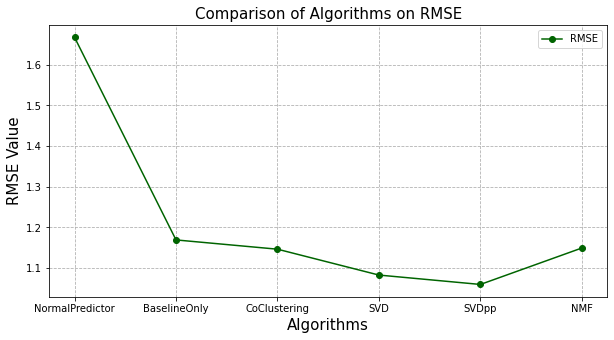

In [ ]:
x_algo = []
rmse = []
for record in benchmark:
  rmse.append(record['test_rmse'])
  x_algo.append(record['Algorithm'])

plt.figure(figsize=(10,5))

plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

### Prameter tuning

In [ ]:
# Parameter tuning
svd_param_grid = {'n_epochs': [15, 20, 25], 
                  'lr_all': [0.007, 0.01, 0.012],
                  'reg_all': [0.02, 0.05]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse'], cv=3)
svd_gs.fit(data)

In [ ]:
# svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse'], cv=5, n_jobs=5)
# svdpp_gs.fit(data)

In [ ]:
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4))
print('RMSE =', svd_gs.best_params['rmse'])

SVD   - RMSE: 1.0472
RMSE = {'n_epochs': 25, 'lr_all': 0.012, 'reg_all': 0.02}
